In [1]:
%matplotlib notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import cmath
import importlib as imp
%cd ../

/media/work/docs/codes/c++/QSVT_framework/simulations


In [2]:
import os
import qiskit
import XW_waves.xw_1d as xw
mix = xw.mix
mse = xw.mse
reload = mix.reload_module
import pylib.circuit_lib as lib
os.getpid()

21957

In [21]:
# ----------------------------------------------------------------------
# --- 1-QUBIT GATE: Read results from the C++ sim. of the PE circuit ---
# ----------------------------------------------------------------------
reload(mse)

om = mse.MeasOracle__()
om.path_ = "./tests/test_phase_estimation/"
om.pname_ = "AA1"
om.open()
eigphase = om.constants_["th"]/2. 

Reading the file ./tests/test_phase_estimation//AA1_circuit_OUTPUT.hdf5...
Name of the simulation is AA1
Simulation has been performed  04-04-2022 13:18:11


<IPython.core.display.Javascript object>


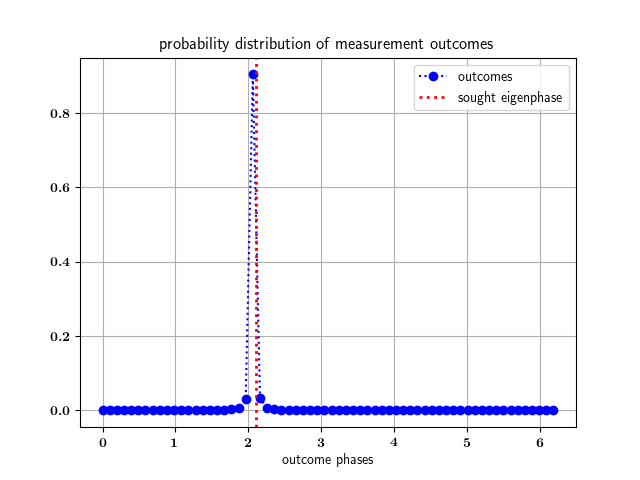

sought-for eigenphase.: 2.100e+00


In [22]:
# ------------------------------------------------------
# --- 1-QUBIT GATE: Form a histogram: [phase, prob] ---
# ------------------------------------------------------
reload(mse)
probs_int = mse.calc_tot_prob_wrt(
    om.output_all_states_[0], 
    range(om.dd_["reg-shifts"]["y"], om.dd_["regs"]["y"])
)
hist_res = mse.pe_form_hist(probs_int)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    hist_res["phases"], 
    hist_res["probs"], 
    color='b', marker="o", linestyle = ':', label = "outcomes"
)
ax.axvline(x=eigphase, linestyle = ':', color='r', linewidth = 2, label="sought eigenphase")
plt.xlabel("outcome phases")
plt.title("probability distribution of measurement outcomes")
ax.legend()
plt.grid(True)
plt.show()

print("sought-for eigenphase.: {:0.3e}".format(eigphase))

In [36]:
# ----------------------------------------------------------------------
# --- 3-QUBIT GATE: Read results from the C++ sim. of the PE circuit ---
# ----------------------------------------------------------------------
reload(mse)

om3 = mse.MeasOracle__()
om3.path_ = "./tests/test_phase_estimation/"
om3.pname_ = "AA3"
om3.open()
eigen_phase_ = om3.constants_["sought_eigphase"]

Reading the file ./tests/test_phase_estimation//AA3_circuit_OUTPUT.hdf5...
Name of the simulation is AA3
Simulation has been performed  04-04-2022 13:45:19


<IPython.core.display.Javascript object>


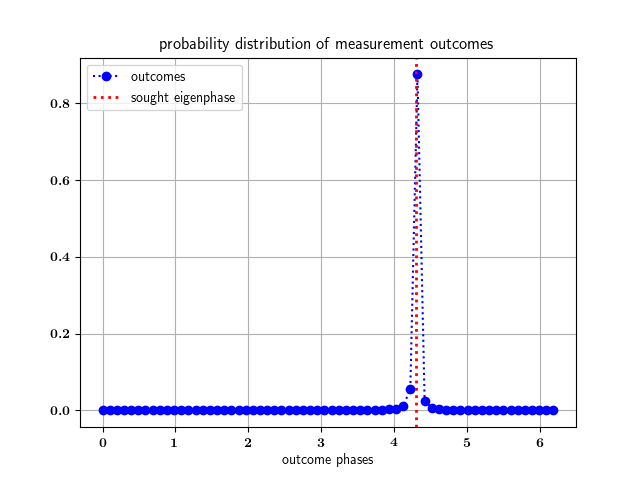

sought-for eigenphase.: 4.300e+00


In [37]:
# ------------------------------------------------------
# --- 3-QUBIT GATE: Form a histogram: [phase, prob] ---
# ------------------------------------------------------
reload(mse)
probs_int = mse.calc_tot_prob_wrt(
    om3.output_all_states_[0], 
    range(om3.dd_["reg-shifts"]["y"], om3.dd_["regs"]["y"])
)
hist_res = mse.pe_form_hist(probs_int)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    hist_res["phases"], 
    hist_res["probs"], 
    color='b', marker="o", linestyle = ':', label = "outcomes"
)
ax.axvline(x=eigen_phase_, linestyle = ':', color='r', linewidth = 2, label="sought eigenphase")
plt.xlabel("outcome phases")
plt.title("probability distribution of measurement outcomes")
ax.legend()
plt.grid(True)
plt.show()

print("sought-for eigenphase.: {:0.3e}".format(eigen_phase_))

In [ ]:
# --------------------------------------------------------------
# --- THE SAME PE ANALYSIS in QISKIT ---
# --------------------------------------------------------------

In [3]:
def Ry(th):
    th2 = th/2.
    return np.array([
        [np.cos(th2), - np.sin(th2)],
        [np.sin(th2),   np.cos(th2)]
    ])

def Rz(th):
    th2 = th/2.
    return np.array([
        [np.exp(-1j*th2),              0],
        [              0, np.exp(1j*th2)]
    ])

def get_eval(th):
    return np.exp(1j*th/2.)

def get_evec():
    coef = 1./np.sqrt(2)
    return coef * np.array([1j, 1])

In [39]:
# ------------------------------------
# --- Analysis of the gate Ry ---
# ------------------------------------

# Ry has eigenvalues: exp(+- i*th_/2)


th_ = 4.2
eigen_phase_ = th_/2.

evals, evecs = np.linalg.eig(Ry(th_))

print("--- numerical eigenvalues ---")
print(evals)

print("\n--- numerical eigenvectors ---")
for ii in range(len(evals)):
    print(evecs[:,ii])

print("\n--- analytical eigenvalues ---")
print("{:16.3f}, {:16.3f}".format(np.exp(1j*th_/2.), np.exp(-1j*th_/2.)))

print("\n--- Ry * evec ---")
res = Ry(th_) @ get_evec()
print(res)

print("\n--- recheck analytical eigevalue and eigenvector ---")
res = Ry(th_) @ get_evec() - get_eval(th_) * get_evec()
print(res)

del res, evals, evecs

--- numerical eigenvalues ---
[-0.505+0.863j -0.505-0.863j]

--- numerical eigenvectors ---
[0.707+0.j    0.   -0.707j]
[0.707-0.j    0.   +0.707j]

--- analytical eigenvalues ---
   -0.505+0.863j,    -0.505-0.863j

--- Ry * evec ---
[-0.61 -0.357j -0.357+0.61j ]

--- recheck analytical eigevalue and eigenvector ---
[0.+0.j 0.+0.j]


In [40]:
# -------------------------------------------------------
# --- 1-QUBIT GATE: Create the initialization circuit ---
# -------------------------------------------------------
reload(lib)

a_ = qiskit.QuantumRegister(1, "a")

qc = qiskit.QuantumCircuit(a_, name="init")

# prepare the eigenvector of Ry:
qc.h(a_)
qc.x(a_); qc.p(np.pi/2., a_); qc.x(a_)

gINIT_ = qc.to_gate()

qc.ry(th_, a_)
str_wv, _, _ = lib.Wavefunction_adv(qc, column=True, systems=[1], width=10)
print(str_wv)
del str_wv

print(qc.draw(fold = 110))

del qc

       -0.610-0.357j |0>   
       -0.357+0.610j |1>   

   ┌───┐┌───┐┌────────┐┌───┐┌─────────┐
a: ┤ H ├┤ X ├┤ P(π/2) ├┤ X ├┤ Ry(4.2) ├
   └───┘└───┘└────────┘└───┘└─────────┘


In [42]:
# ------------------------------------------------------------------------
# --- 1-QUBIT: Create the operator, which eigephase is to be estimated ---
# ------------------------------------------------------------------------
qc = qiskit.QuantumCircuit(a_, name="U")
qc.ry(th_, a_)
gU_ = qc.to_gate()
del qc

--- Resulting circuit ---
       ┌───┐                                        ┌───────┐┌─┐               
 m_0: ─┤ H ├────■───────────────────────────────────┤0      ├┤M├───────────────
       ├───┤    │                                   │       │└╥┘┌─┐            
 m_1: ─┤ H ├────┼─────■─────────────────────────────┤1      ├─╫─┤M├────────────
       ├───┤    │     │                             │       │ ║ └╥┘┌─┐         
 m_2: ─┤ H ├────┼─────┼─────■───────────────────────┤2      ├─╫──╫─┤M├─────────
       ├───┤    │     │     │                       │  F_dg │ ║  ║ └╥┘┌─┐      
 m_3: ─┤ H ├────┼─────┼─────┼─────■─────────────────┤3      ├─╫──╫──╫─┤M├──────
       ├───┤    │     │     │     │                 │       │ ║  ║  ║ └╥┘┌─┐   
 m_4: ─┤ H ├────┼─────┼─────┼─────┼──────■──────────┤4      ├─╫──╫──╫──╫─┤M├───
       ├───┤    │     │     │     │      │          │       │ ║  ║  ║  ║ └╥┘┌─┐
 m_5: ─┤ H ├────┼─────┼─────┼─────┼──────┼──────■───┤5      ├─╫──╫──╫──╫──╫─┤M├
      ┌┴───┴─┐

<IPython.core.display.Javascript object>


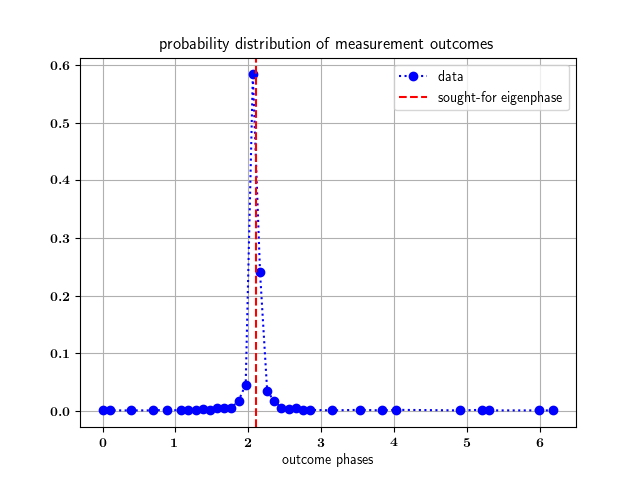

sought-for eigenphase: 2.100


In [43]:
# -----------------------------------------------------------
# --- 1-QUBIT: Phase estimation (estimation of the th_/2) ---
# -----------------------------------------------------------
# Estimate the eigenphase of the operator gU_ taken the corresponding egenvector as the initial state;
# the initial state is prepared by the operator gINIT_.
reload(lib)

nm = 6
dd = lib.get_phase_estimation(nm, a_, gINIT_, gU_)
print("--- Resulting circuit ---")
if(nm <= 8):
    print(dd["circuit"].draw(fold = 110))

outcome_phases = dd["phases"]
probs_distr    = dd["probs"]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    outcome_phases, 
    probs_distr, 
    color='b', marker="o", linestyle = ':', label = "data"
)
ax.axvline(x=eigen_phase_, color='r', linestyle = '--', label = "sought-for eigenphase")
plt.xlabel("outcome phases")
plt.title("probability distribution of measurement outcomes")
ax.legend()
plt.grid(True)
plt.show()

print("sought-for eigenphase: {:0.3f}".format(eigen_phase_))

In [4]:
# ------------------------------------
# --- Analysis of a 3-QUBIT gate ---
# ------------------------------------

th1_ = 4.2
th2_ = 3.2
th3_ = 1.2

id_eig = 7

temp       = np.kron(Rz(th2_), Rz(th1_))
res_matrix = np.kron(Rz(th3_), temp)
evals, evecs = np.linalg.eig(res_matrix)

print("--- numerical eigenvalues ---")
print(evals)

print("\n--- numerical eigenvectors ---")
for ii in range(len(evals)):
    print(evecs[:,ii])

# chosen an eigenvector and eigenvalue:
eig_value = evals[id_eig]
eig_vec = evecs[:, id_eig]

eig_phase_ = cmath.phase(eig_value)
if(eig_phase_ < 0 ):
    eig_phase_ += 2*np.pi

print()
print("chosen eigenvalue: \t{:20.3f}".format(eig_value))
print("corresponding eigenphase: {:0.3f}".format(eig_phase_))
print("rechecked eigenvalue: \t{:20.3f}".format(np.exp(1j*eig_phase_)))
print("chosen eigenvector:")
print(eig_vec)


print()
print("th1_ \t\t\t{:0.3}".format(th1_))
print("th2_ \t\t\t{:0.3}".format(th2_))
print("th3_ \t\t\t{:0.3}".format(th3_))
print("sought_eigphase \t{:0.3}".format(eig_phase_))


del temp, res_matrix, evals, evecs

--- numerical eigenvalues ---
[-0.401+0.916j  0.995-0.1j    0.454-0.891j -0.999+0.042j -0.999-0.042j
  0.454+0.891j  0.995+0.1j   -0.401-0.916j]

--- numerical eigenvectors ---
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]

chosen eigenvalue: 	       -0.401-0.916j
corresponding eigenphase: 4.300
rechecked eigenvalue: 	       -0.401-0.916j
chosen eigenvector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]

th1_ 			4.2
th2_ 			3.2
th3_ 			1.2
sought_eigphase 	4.3


In [5]:
# ----------------------------------------------------------
# --- 3-QUBIT GATE: Create the initialization operator ---
# ----------------------------------------------------------
reload(lib)

a3_ = qiskit.QuantumRegister(3, "a")
qc = qiskit.QuantumCircuit(a3_, name="init")

qc.x(a3_[0]); 
qc.x(a3_[1]);
qc.x(a3_[2]);
gINIT3_ = qc.to_gate()

# --- check the initialization ---
qc.rz(th1_, a3_[0])
qc.rz(th2_, a3_[1])
qc.rz(th3_, a3_[2])
str_wv, _, _ = lib.Wavefunction_adv(qc, column=True, systems=[1], width=10)
print(str_wv)
del str_wv

print(qc.draw(fold = 110))

del qc

       -0.401-0.916j |111>   

     ┌───┐┌─────────┐
a_0: ┤ X ├┤ Rz(4.2) ├
     ├───┤├─────────┤
a_1: ┤ X ├┤ Rz(3.2) ├
     ├───┤├─────────┤
a_2: ┤ X ├┤ Rz(1.2) ├
     └───┘└─────────┘


In [6]:
# -----------------------------------------------------------------------------
# --- 3-QUBIT GATE: Create the operator, which eigephase is to be estimated ---
# -----------------------------------------------------------------------------
qc = qiskit.QuantumCircuit(a3_, name="U")
qc.rz(th1_, a3_[0])
qc.rz(th2_, a3_[1])
qc.rz(th3_, a3_[2])
gU3_ = qc.to_gate()
del qc

--- Resulting circuit ---
        ┌───┐                                              ┌───────┐┌─┐               
 m_0: ──┤ H ├─────■────────────────────────────────────────┤0      ├┤M├───────────────
        ├───┤     │                                        │       │└╥┘┌─┐            
 m_1: ──┤ H ├─────┼──────■─────────────────────────────────┤1      ├─╫─┤M├────────────
        ├───┤     │      │                                 │       │ ║ └╥┘┌─┐         
 m_2: ──┤ H ├─────┼──────┼──────■──────────────────────────┤2      ├─╫──╫─┤M├─────────
        ├───┤     │      │      │                          │  F_dg │ ║  ║ └╥┘┌─┐      
 m_3: ──┤ H ├─────┼──────┼──────┼──────■───────────────────┤3      ├─╫──╫──╫─┤M├──────
        ├───┤     │      │      │      │                   │       │ ║  ║  ║ └╥┘┌─┐   
 m_4: ──┤ H ├─────┼──────┼──────┼──────┼──────■────────────┤4      ├─╫──╫──╫──╫─┤M├───
        ├───┤     │      │      │      │      │            │       │ ║  ║  ║  ║ └╥┘┌─┐
 m_5: ──┤ H ├────

<IPython.core.display.Javascript object>


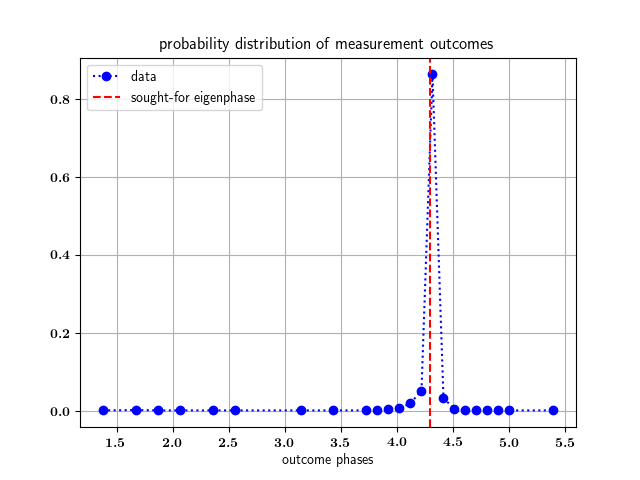

sought-for eigenphase: 4.300


In [7]:
# -----------------------------------------------------------
# --- 3-QUBIT GATE: Phase estimation  ---
# -----------------------------------------------------------
reload(lib)

nm = 6

dd = lib.get_phase_estimation(nm, a3_, gINIT3_, gU3_)
print("--- Resulting circuit ---")
if(nm <= 8):
    print(dd["circuit"].draw(fold = 110))
    
outcome_phases = dd["phases"]
probs_distr    = dd["probs"]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    outcome_phases, 
    probs_distr, 
    color='b', marker="o", linestyle = ':', label = "data"
)
ax.axvline(x=eig_phase_, color='r', linestyle = '--', label = "sought-for eigenphase")
plt.xlabel("outcome phases")
plt.title("probability distribution of measurement outcomes")
ax.legend()
plt.grid(True)
plt.show()

print("sought-for eigenphase: {:0.3f}".format(eig_phase_))

In [11]:
reload(lib)

nm = 4
qc_phase_estimation, m, cl = lib.get_phase_estimation_circuit(nm, a3_, gINIT3_, gU3_)
str_wv, _, _ = lib.Wavefunction_adv(qc_phase_estimation, column=True, systems=[nm,len(a3_)], width=10)
print(str_wv)

del qc_phase_estimation, m, cl

        0.008+0.009j |0000>|111>   
        0.005+0.009j |1000>|111>   
        0.003+0.009j |0100>|111>   
        0.001+0.010j |1100>|111>   
       -0.000+0.010j |0010>|111>   
       -0.003+0.010j |1010>|111>   
       -0.005+0.011j |0110>|111>   
       -0.008+0.011j |1110>|111>   
       -0.013+0.012j |0001>|111>   
       -0.023+0.013j |1001>|111>   
       -0.050+0.018j |0101>|111>   
        0.985-0.147j |1101>|111>   
        0.048+0.002j |0011>|111>   
        0.024+0.006j |1011>|111>   
        0.016+0.007j |0111>|111>   
        0.011+0.008j |1111>|111>   

